In [1]:
import os
import sys
import datetime
import pprint
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import _init_paths
from config.default import cfg_from_list, cfg_from_file, update_config
from config.default import config as cfg
from core.engine import creat_data_loader, str_gpus, \
    AverageMeter, accuracy, list2acc, adjust_learning_rate_normal
from core.functions import prepare_env
from utils import mkdir, Logger
from cams import evaluate_cls_loc

import torch
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torch.nn.functional as F

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

from models.vgg import vgg16_cam
from timm.models import create_model as create_deit_model
from timm.optim import create_optimizer
from urllib.request import urlretrieve

In [2]:
config_file = '../configs/ILSVRC/deit_tscam_small_patch16_224.yaml'
cfg_from_file(config_file)
cfg.BASIC.ROOT_DIR = '../'

/home/ubuntu/Workspace/GaoWei/WSOL/ts-cam/tools_cam/../lib/config/default.py:121: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_config = AttrDict(yaml.load(fopen))


In [3]:
_ , val_loader = creat_data_loader(cfg, os.path.join(cfg.BASIC.ROOT_DIR, cfg.DATA.DATADIR))

==> Preparing data...
done!


In [4]:
len(val_loader)

196

In [5]:
model = create_deit_model(
            cfg.MODEL.ARCH,
            pretrained=True,
            num_classes=cfg.DATA.NUM_CLASSES,
            drop_rate=0.0,
            drop_path_rate=0.1,
            drop_block_rate=None,
        )
model = model.cuda()

Removing key head.weight from pretrained checkpoint


In [6]:
checkpoint = torch.load('../ckpt/ImageNet/deit_tscam_small_patch16_224_CAM-NORMAL_SEED26_CAM-THR0.12_BS256_2021-03-25-20-31/ckpt/model_epoch12.pth')

In [7]:
pretrained_dict = {k[7:]: v for k, v in checkpoint['state_dict'].items()}

In [8]:
model.load_state_dict(pretrained_dict)
model.eval()

TSCAM(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [208]:
im = Image.open("../data/ImageNet_ILSVRC2012/val/n01608432/ILSVRC2012_val_00027693.JPEG").convert('RGB')
x = transform(im)
x.size()

torch.Size([3, 224, 224])

In [209]:
im

In [210]:
with torch.no_grad():
    x_logits, tscams = model(x.unsqueeze(0).cuda(), True)

In [211]:
tscams.shape

torch.Size([1, 1000, 14, 14])

In [212]:
x_probs = F.softmax(x_logits, dim=-1)
pred_cls_id = x_probs.argmax()

(-0.5, 499.5, 374.5, -0.5)

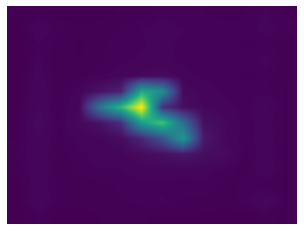

In [213]:
cam_pred = tscams[0,pred_cls_id,:,:].detach().cpu().numpy()
mask_pred = cv2.resize(cam_pred, im.size)
mask_min_v, mask_max_v = mask_pred.min(), mask_pred.max()
mask_pred = (mask_pred - mask_min_v) / (mask_max_v - mask_min_v)
mask_image = (mask_pred[..., np.newaxis] * im).astype("uint8")
plt.imshow(mask_pred)
plt.axis('off')

In [214]:
plt.imshow(mask_image)
plt.axis('off')

(-0.5, 499.5, 374.5, -0.5)

In [215]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(mask_image)

In [216]:
""" 
Note:
  Another way to generate attention maps and ts-cam. This method is used in paper
  <https://arxiv.org/pdf/2010.11929.pdf>
  And this method is called Attention Rollout, for more details please 
  read paper <https://arxiv.org/pdf/2005.00928.pdf>
"""
with torch.no_grad():
    x_cls, x_patch, attn_weights_head = model.forward_features(x.unsqueeze(0).cuda())
    n, p, c = x_patch.shape
    x_patch = torch.reshape(x_patch, [n, int(p**0.5), int(p**0.5), c])
    x_patch = x_patch.permute([0, 3, 1, 2])
    x_patch = x_patch.contiguous()
    x_logits = model.head(x_patch)
    
    attn_weights_head = torch.stack(attn_weights_head)     #n_layer x n_batch x n_head x n_token x n_token
    attn_weights = torch.mean(attn_weights_head, dim=2)    #n_layer x n_batch x n_token x n_token
    residual_att = torch.eye(attn_weights.size(2)).unsqueeze(0).unsqueeze(1).to(attn_weights.get_device())    # 12 * B * N * N
    aug_att_mat = attn_weights + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    joint_attns = torch.zeros(attn_weights.size()).to(attn_weights.get_device())
    joint_attns[0] = aug_att_mat[0]
    for n in range(1, aug_att_mat.size()[0]):
        joint_attns[n] = torch.matmul(aug_att_mat[n], joint_attns[n-1])
    feature_map = x_logits.detach().clone()
    feature_map_softmax = F.softmax(feature_map, 1)
    b, c, h, w = feature_map.shape
    
    cams_re = joint_attns[-1][:, 0, 1:].reshape([b, h, w]).unsqueeze(1)  # n_batch x n_class x n_token x n_token
    tscams_ar = cams_re * feature_map          # tscam where semantic-agnostic attention map is generated using 
                                               # Attention Rollout Method.

In [217]:
"""
Visualize more attention maps from all layers(average every layer), i_th head for class token
Note: attn_weights_head is of shape n_layer x n_batch x n_head x n_token x n_token
"""
attn = attn_weights_head[:].mean(0)[0][4][0,1:].reshape(14, 14).detach().cpu().numpy()
attn=cv2.resize(attn, im.size)
plt.imshow(attn)

In [218]:
"""
Visualize more attention maps from all layers(average every layer), all head(average everay head) for j_th patch token
Note: attn_weights_head is of shape n_layer x n_batch x n_head x n_token x n_token
"""
attn = attn_weights_head[:].sum(0)[0].sum(0)[65,1:].reshape(14, 14).detach().cpu().numpy()
attn=cv2.resize(attn, im.size)
plt.imshow(attn)

In [219]:
"""
Visualize more attention maps from last layer, i_th head,  for class token
Note: attn_weights_head is of shape n_layer x n_batch x n_head x n_token x n_token
"""
attn = attn_weights_head[-2][0][2][0,1:].reshape(14, 14).detach().cpu().numpy()
attn=cv2.resize(attn, im.size)
plt.imshow(attn)

(-0.5, 499.5, 374.5, -0.5)

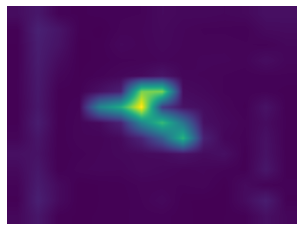

In [220]:
"""
Visualize more attention maps from all layer(sum everay layer), all head(sum everay head),for class token
Note: attn_weights is of shape n_layer x n_batch x n_token x n_token
"""
attn = attn_weights[:].sum(0)[0][0,1:].reshape(14, 14).detach().cpu().numpy()
attn=cv2.resize(attn, im.size)
plt.imshow(attn)
plt.axis('off')

In [221]:
"""
Visualize more attention maps from last 2 layer, all head(sum everay head),for j_th patch token
Note: attn_weights is of shape n_layer x n_batch x n_token x n_token
"""
attn = attn_weights[-2][0][66,1:].reshape(14, 14).detach().cpu().numpy()
attn=cv2.resize(attn, im.size)
plt.imshow(attn)

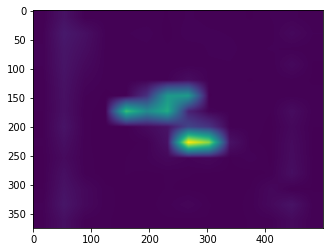

In [222]:
"""
Visualize more attention maps from last layer, all head(sum everay head),j_th patch token
Note: attn_weights is of shape n_layer x n_batch x n_token x n_token
"""
attn = attn_weights[-1,0][96,1:].reshape(14, 14).detach().cpu().numpy()
attn=cv2.resize(attn, im.size)
plt.imshow(attn)

In [223]:
"""
Visualize more attention maps from last layer, all head(sum everay head),for all patch token(sum all patch token)
Note: attn_weights is of shape n_layer x n_batch x n_token x n_token
"""
attn = attn_weights[-1,0, 1:].sum(0)[1:].reshape(14, 14).detach().cpu().numpy()
attn=cv2.resize(attn, im.size)
plt.imshow(attn)

(-0.5, 499.5, 374.5, -0.5)

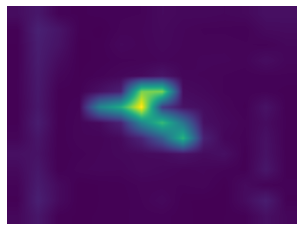

In [224]:
"""
Visualize more attention maps from all layer(sum everay layer), all head(sum everay head),for class token
Note: attn_weights is of shape n_layer x n_batch x n_token x n_token
"""
attn = attn_weights.sum(0)[0, 0][1:].reshape(14, 14).detach().cpu().numpy()
attn=cv2.resize(attn, im.size)
plt.imshow(attn)
plt.axis('off')

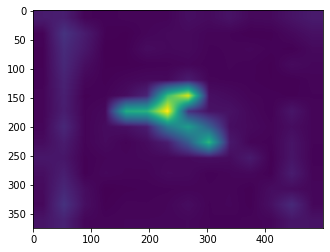

In [225]:
"""
Visualize more attention maps from all layer(sum everay layer), all head(sum everay head),for all patch token
Note: attn_weights is of shape n_layer x n_batch x n_token x n_token
"""
attn = attn_weights.sum(0)[0, 1:].sum(0)[1:].reshape(14, 14).detach().cpu().numpy()
attn=cv2.resize(attn, im.size)
plt.imshow(attn)

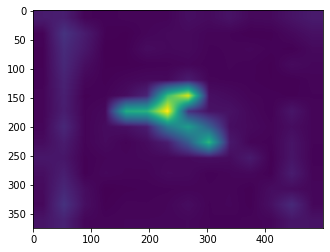

In [226]:
attn = attn_weights.sum(0)[0, 1:].sum(0)[1:].reshape(14, 14).detach().cpu().numpy()
a_min, a_max = attn.min(), attn.max()
attn = (attn - a_min) / (a_max - a_min)
attn = cv2.resize(attn, im.size)
plt.imshow(attn)

(-0.5, 223.5, 223.5, -0.5)

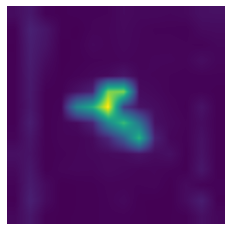

In [227]:
"""
Visualization of semantis-agnostic attention map A_*
Note: attn_weights is of shape n_layer x n_batch x n_token x n_token
"""
attn = attn_weights.mean(0)[0, 0][1:].reshape(14, 14).detach().cpu().numpy()
attn=cv2.resize(attn, (224, 224))
#plt.imshow(attn, cmap='gray')
plt.imshow(attn)
plt.axis('off')

In [228]:
"""
Visualize more attention maps from 1-12 layer,for class token
Note: attn_weights is of shape n_layer x n_batch x n_token x n_token
"""
left = 0.1  # the left side of the subplots of the figure
right = 0.9   # the right side of the subplots of the figure
bottom = 0.1  # the bottom of the subplots of the figure
top = 0.45     # the top of the subplots of the figure
wspace = 0.05  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.05  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 4.))
#fig.tight_layout()
for row in range(2):
    for col in range(0,6):
        #axes[row][col-1].set_title(str(row)+'-'+str(col))
        attn_l = attn_weights[row*6+col,0][0,1:].reshape(14, 14).detach().cpu().numpy()
        attn_l=cv2.resize(attn_l, (224, 224))
        axes[row][col].imshow(attn_l)
        axes[row][col].axis('off')
#plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.subplots_adjust(wspace=0.001, hspace=0.04)
plt.show()

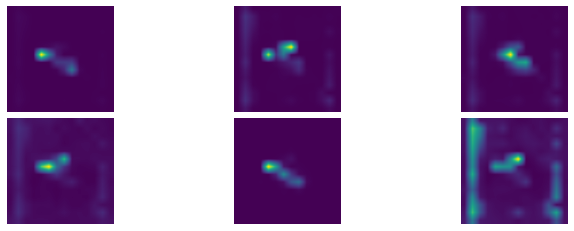

In [229]:
"""
Visualize more attention maps from second to last layer,for each head and class token
Note: attn_weights is of shape n_layer x n_batch x n_token x n_token
"""
left = 0.1  # the left side of the subplots of the figure
right = 0.9   # the right side of the subplots of the figure
bottom = 0.1  # the bottom of the subplots of the figure
top = 0.45     # the top of the subplots of the figure
wspace = 0.1  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.1  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 4))
#fig.tight_layout()
for row in range(2):
    for col in range(0,3):
        #axes[row][col-1].set_title(str(row)+'-'+str(col))
        #attn_l = attn_weights[row*6+col,0][0,1:].reshape(14, 14).detach().cpu().numpy()
        attn_l = attn_weights_head[-2,0][row*3+col][0,1:].reshape(14, 14).detach().cpu().numpy()
        attn_l=cv2.resize(attn_l, (224, 224))
        axes[row][col].imshow(attn_l)
        axes[row][col].axis('off')
#plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [230]:
"""
Visualize more attention maps from all layer,for each head and class token
Note: attn_weights is of shape n_layer x n_batch x n_token x n_token
"""
left = 0.1  # the left side of the subplots of the figure
right = 0.9   # the right side of the subplots of the figure
bottom = 0.1  # the bottom of the subplots of the figure
top = 0.45     # the top of the subplots of the figure
wspace = 0.05  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.05  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(12, 4))
#fig.tight_layout()
for row in range(1):
    for col in range(0,6):
        #axes[row][col-1].set_title(str(row)+'-'+str(col))
        #attn_l = attn_weights[row*6+col,0][0,1:].reshape(14, 14).detach().cpu().numpy()
        attn_l = attn_weights_head.sum(0)[0][row*6+col][0,1:].reshape(14, 14).detach().cpu().numpy()
        attn_l=cv2.resize(attn_l, (224, 224))
        axes[col].imshow(attn_l)
        axes[col].axis('off')
        #axes[row][col].imshow(attn_l)
        #axes[row][col].axis('off')
#plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [231]:
attn_weights_head.shape

torch.Size([12, 1, 6, 197, 197])

In [232]:
"""
Visualize more attention maps from last layer,for each patch token
Note: attn_weights is of shape n_layer x n_batch x n_token x n_token
"""
left = 0.0  # the left side of the subplots of the figure
right = 0.0   # the right side of the subplots of the figure
bottom = 0.0  # the bottom of the subplots of the figure
top = 0.0     # the top of the subplots of the figure
wspace = 0.1  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.5  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
fig, axes = plt.subplots(nrows=14, ncols=14, figsize=(30, 30))
for row in range(14):
    for col in range(0,14):
        #axes[row][col-1].set_title(str(row)+'-'+str(col))
        attn = attn_weights[-2,0][1:][row*14+col,1:].reshape(14, 14).detach().cpu().numpy()
        attn=cv2.resize(attn, (224, 224))
        axes[row][col].imshow(attn)
        axes[row][col].axis('off')
#plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
#fig.tight_layout(pad=0.1)
plt.show()

In [233]:
"""
Visualize more attention maps from last layer, for one specific head, for each patch token
Note: attn_weights is of shape n_layer x n_batch x n_token x n_token
"""
left = 0.0  # the left side of the subplots of the figure
right = 0.0   # the right side of the subplots of the figure
bottom = 0.0  # the bottom of the subplots of the figure
top = 0.0     # the top of the subplots of the figure
wspace = 0.1  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.1  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
fig, axes = plt.subplots(nrows=14, ncols=14, figsize=(30, 30))
for row in range(14):
    for col in range(0,14):
        #axes[row][col-1].set_title(str(row)+'-'+str(col))
        attn = attn_weights.mean(0)[0][1:][row*14+col,1:].reshape(14, 14).detach().cpu().numpy()
        attn=cv2.resize(attn, (224, 224))
        axes[row][col].imshow(attn)
        axes[row][col].axis('off')
#plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#fig.tight_layout(pad=0.1)
plt.show()

In [234]:
"""
Visualize more attention maps from all layer(sum all layer), for one specific head, for each patch token
Note: attn_weights is of shape n_layer x n_batch x n_token x n_token
"""
left = 0.0  # the left side of the subplots of the figure
right = 0.0   # the right side of the subplots of the figure
bottom = 0.0  # the bottom of the subplots of the figure
top = 0.0     # the top of the subplots of the figure
wspace = 0.1  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.1  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
fig, axes = plt.subplots(nrows=14, ncols=14, figsize=(30, 30))
for row in range(14):
    for col in range(0,14):
        #axes[row][col-1].set_title(str(row)+'-'+str(col))
        attn = attn_weights_head[-1,0, 5][1:][row*14+col,1:].reshape(14, 14).detach().cpu().numpy()
        attn=cv2.resize(attn, (224, 224))
        axes[row][col].imshow(attn)
        axes[row][col].axis('off')
#plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.subplots_adjust(wspace=0.005, hspace=0.005)
#fig.tight_layout(pad=0.1)
plt.show()

In [236]:
"""
Visualize more attention maps from all layer(sum all layer), for one specific head, for each patch token
Note: attn_weights is of shape n_layer x n_batch x n_token x n_token
"""
left = 0.0  # the left side of the subplots of the figure
right = 0.0   # the right side of the subplots of the figure
bottom = 0.0  # the bottom of the subplots of the figure
top = 0.0     # the top of the subplots of the figure
wspace = 0.1  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.1  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
fig, axes = plt.subplots(nrows=14, ncols=14, figsize=(30, 30))
for row in range(14):
    for col in range(0,14):
        #axes[row][col-1].set_title(str(row)+'-'+str(col))
        #attn = attn_weights_head[-1,0, 5][1:][row*14+col,1:].reshape(14, 14).detach().cpu().numpy()
        attn = attn_weights_head.sum(0)[0, 5][1:][row*14+col,1:].reshape(14, 14).detach().cpu().numpy()
        attn=cv2.resize(attn, (224, 224))
        axes[row][col].imshow(attn)
        axes[row][col].axis('off')
#plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
#fig.tight_layout(pad=0.1)
plt.show()

In [237]:
attn_weights_head.shape

torch.Size([12, 1, 6, 197, 197])

In [238]:
x_logits.shape

torch.Size([1, 1000, 14, 14])

# Generate Localization Boxes based on TSCAM

(-0.5, 499.5, 374.5, -0.5)

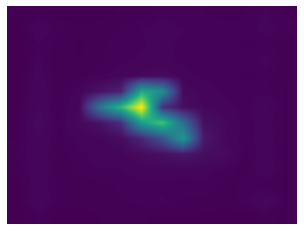

In [239]:
cam_pred = tscams[0,pred_cls_id,:,:].detach().cpu().numpy()
mask_pred = cv2.resize(cam_pred, im.size)
mask_min_v, mask_max_v = mask_pred.min(), mask_pred.max()
mask_pred = (mask_pred - mask_min_v) / (mask_max_v - mask_min_v)
#mask_image = (mask_pred[..., np.newaxis] * im).astype("uint8")
plt.imshow(mask_pred)
plt.axis('off')

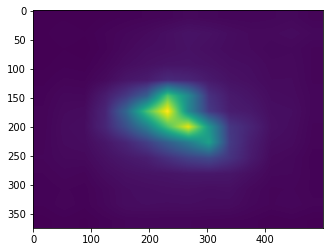

In [240]:
"""
Semantic-gnostic attention map is generated using Attention Rollout Method.
Please refer to paper <https://arxiv.org/pdf/2010.11929.pdf> and <https://arxiv.org/pdf/2005.00928.pdf>
"""
cams_pred_ar = tscams_ar[0, pred_cls_id,:,:].cpu().numpy()
mask_pred_ar = cv2.resize(cams_pred_ar, im.size)
mask_ar_min_v, mask_ar_max_v = mask_pred_ar.min(), mask_pred_ar.max()
mask_pred_ar = (mask_pred_ar - mask_ar_min_v) / (mask_ar_max_v - mask_ar_min_v)
plt.imshow(mask_pred_ar)

In [241]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 16))

ax1.set_title('Input Image')
ax2.set_title('Token-Semantic Coupled Attention Map')
ax3.set_title('Binary Map')

_, mask_pred_binary_map = cv2.threshold(mask_pred,
                                        mask_pred.max()*0.12, 1,
                                        cv2.THRESH_TOZERO)
contours, _ = cv2.findContours((mask_pred_binary_map*255).astype(np.uint8),
                                       cv2.RETR_TREE,
                                       cv2.CHAIN_APPROX_SIMPLE)
w,h=im.size
if len(contours) != 0:
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    estimated_bbox = [x, y, x + w, y + h]
    color1=(0, 0, 255)
heatmap = cv2.applyColorMap((mask_pred*255).astype(np.uint8), cv2.COLORMAP_TURBO)
blend = np.array(im) * 0.5 + heatmap * 0.5
x1,y1,x2,y2 = estimated_bbox
im_box = cv2.rectangle(np.array(im), (x1, y1), (x2, y2), color1, 2)
_ = ax1.imshow(im_box)               # Visualize Input Image with Estimated Box
_ = ax2.imshow(mask_pred)            # Visualize TS-CAM which is localization map for estimating object box
_ = ax3.imshow(mask_pred_binary_map) # Visualize Binary Map

In [242]:
"""
Visualize Input Image with Estimated Object Box and ts-cam.
"""
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im_box, aspect='equal', cmap=plt.cm.rainbow)
I = np.zeros_like(mask_pred_binary_map)
x1,y1,x2,y2 = estimated_bbox
I[y1:y2,x1:x2]=1
ax.imshow(mask_pred, aspect='equal', cmap=plt.cm.jet, alpha = 0.3)
plt.axis('off')
plt.tight_layout()
plt.draw()

# Generate Attention Map Using Attention Rollout

In [243]:
"""
For Attention Rollout method
"""
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 16))

ax1.set_title('Input Image')
ax2.set_title('Token-Semantic Coupled Attention Map')
ax3.set_title('Binary Map')

_, mask_pred_ar_binary_map = cv2.threshold(mask_pred_ar,
                                        mask_pred_ar.max()*0.3, 1,
                                        cv2.THRESH_TOZERO)
contours, _ = cv2.findContours((mask_pred_ar_binary_map*255).astype(np.uint8),
                                       cv2.RETR_TREE,
                                       cv2.CHAIN_APPROX_SIMPLE)
if len(contours) != 0:
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    estimated_bbox_ar = [x, y, x + w, y + h]
    color1=(0, 0, 255)
heatmap = cv2.applyColorMap((mask_pred_ar_binary_map*255).astype(np.uint8), cv2.COLORMAP_JET)
x1, y1, x2, y2 = estimated_bbox_ar
im_box_ar = cv2.rectangle(np.array(im), (x1, y1), (x2, y2), color1, 2)
_ = ax1.imshow(im_box_ar)                   # Visualize Input Image with Estimated Box
_ = ax2.imshow(mask_pred_ar)             # Visualize TS-CAM which is localization map for estimating object box
_ = ax3.imshow(mask_pred_ar_binary_map)  # Visualize Binary Map

In [244]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im_box_ar, aspect='equal', cmap=plt.cm.rainbow)
I = np.zeros_like(mask_pred_ar_binary_map)
x1,y1,x2,y2 = estimated_bbox_ar
I[y1:y2,x1:x2]=1
ax.imshow(mask_pred_ar_binary_map, aspect='equal', cmap=plt.cm.jet, alpha = 0.5)
#ax.scatter(inds[1][-222:],inds[0][-222:], 60, '#FA0026', '*')
box = np.array([40.270714,   0.,       279.72928,  346.1252])
'''
ax.add_patch(
            plt.Rectangle((box[0], box[1]),
                          box[2] - box[0],
                          box[3] - box[1], fill=False,
                          edgecolor='g', linewidth=12, zorder=2)
            )
'''
#ax.contourf(basefeat_np_img_up, 15, cmap=plt.cm.rainbow)
plt.axis('off')
plt.tight_layout()
plt.draw()

## Visualize semantic-agnostic attention maps using Attention Rollout Method

In [245]:
v = joint_attns[-1,0,-1,1:].reshape([int(p**0.5), int(p**0.5)]).cpu().numpy()
mask_v = cv2.resize(v / v.max(), im.size)
im_mask_v = (mask_v[...,np.newaxis] * im).astype("uint8")

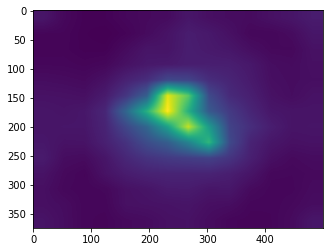

In [246]:
plt.imshow(mask_v)

In [247]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(im_mask_v)

# Try other images from web, Just for fun, Play with it

In [248]:
# Test images from web
# Just type in different image urls
# and try any interesting image you like
# For example, mandarin duck, bird, dragon, sheep, dog, cat 
img_url = "https://img1.baidu.com/it/u=2875857750,1614693218&fm=26&fmt=auto&gp=0.jpg"
urlretrieve(img_url, "../attention_data/img.jpg")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.2255]),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
im_web = Image.open("../attention_data/img.jpg")
x_web = transform(im_web)
x_web.size()

torch.Size([3, 224, 224])

In [249]:
with torch.no_grad():
    x_web_logits, ts_cam_img_web = model(x_web.unsqueeze(0).cuda(), True)

In [250]:
pred_cls_id_web = x_web_logits.argmax()

In [251]:
mask_pred_web = ts_cam_img_web[0,pred_cls_id_web,:,:].detach().cpu().numpy()
mask_pred_web = cv2.resize(mask_pred_web, im_web.size)
v_min_web, v_max_web = mask_pred_web.min(), mask_pred_web.max()
mask_pred_web = (mask_pred_web - v_min_web) / (v_max_web - v_min_web)

In [252]:
plt.imshow(mask_pred_web)

In [206]:
result_web = (mask_pred_web[...,np.newaxis] * im_web).astype("uint8")

In [207]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im_web)
_ = ax2.imshow(result_web)